In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/alex/ECE239AS/DQN

/home/alex/ECE239AS/DQN


/home/alex/anaconda3/envs/239as/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
! pip install numpy torch wandb swig gymnasium[box2d] matplotlib termcolor

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [4]:

from utils import *
import tests

# Reinforcement Learning Part 1: DQN
By Lawrence Liu and Tonmoy Monsoor
## Some General Instructions

- As before, please keep the names of the layer consistent with what is requested in model.py. Otherwise the test functions will not work

- You will need to fill in the model.py, the DQN.py file, the buffer.py file, and the
env_wrapper.py

DO NOT use Windows for this project, gymnasium does is not supported for windows and installing it will be a pain.

### Introduction to the Enviroment
We will be training a DQN agent to play the game of CarRacing. The agent will be trained to play the game using the pixels of the game as an input. The reward structure is as follows for each frame:
- -0.1 for each frame
- +1000/N where N is the number of tiles visited by the car in the episode

The overall goal of this game is to design a agent that is able to play the game with a average test score of above 600. In discrete mode the actions can take 5 actions,
- 0: Do Nothing
- 1: Turn Left
- 2: Turn Right
- 3: Accelerate
- 4: Brake

First let us visualize the game and understand the environment.

In [5]:
import gymnasium as gym
env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')

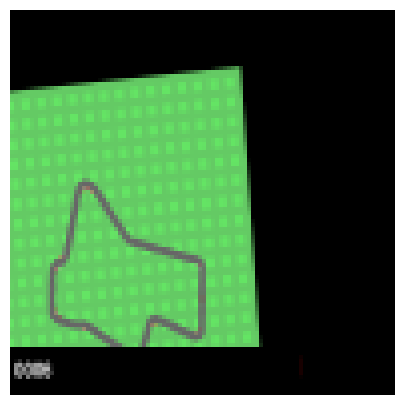

In [6]:

from IPython.display import HTML

frames = []
s, _ = env.reset()

while True:
    a = env.action_space.sample()
    s, r, terminated, truncated, _ = env.step(a)
    frames.append(s)
    if terminated or truncated:
        break


anim = animate(frames)
HTML(anim.to_jshtml())

So a couple things we can note:
- at the beginning of the game, we have 50 frames of the game slowly zooming into the car, we should ignore this period, ie no-op during this period.
- there is a black bar at the bottom of the screen, we should crop this out of the observation. 

In addition, another thing to note is that the current frame doesn't give much information about the velocity and acceleration of the car, and that the car does not move much for each frame.
### Environment Wrapper (5 points)
As a result, you will need to complete `EnvWrapper` in `env_wrapper.py`. You can find more information in the docstring for the wrapper, however the main idea is that it is a wrapper to the environment that does the following:
- skips the first 50 frames of the game
- crops out the black bar and reshapes the observation to a 84x84 image, as well as turning the resulting image to grayscale
- performs the actions for `skip_frames` frames
- stacks the last `num_frames` frames together to give the agent some information about the velocity and acceleration of the car.


In [7]:
from env_wrapper import EnvWrapper

tests.test_wrapper(EnvWrapper)

Passed reset
Passed step


### CNN Model (5 points)
Now we are ready to build the model. Our architecture of the CNN model is the one proposed by Mnih et al in "Human-level control through deep reinforcement learning". Specifically this consists of the following layers:
- A convolutional layer with 32 filters of size 8x8 with stride 4 and relu activation
- A convolutional layer with 64 filters of size 4x4 with stride 2 and relu activation
- A convolutional layer with 64 filters of size 3x3 with stride 1 and relu activation
- A fully connected layer with 512 units and relu activation
- A fully connected layer with the number of outputs of the environment

Please implement this model `Nature_Paper_Conv` in `model.py` as well as the helper 
`MLP` class.

In [8]:
import model
tests.test_model_DQN(model.Nature_Paper_Conv)

Passed


### DQN (40 points)
Now we are ready to implement the DQN algorithm. 

![title](DQN.png)

#### Replay Buffer (5 points)
First start by implementing the DQN replay buffer `ReplayBufferDQN` in `buffer.py`. This buffer will store the transitions of the agent and sample them for training. 

In [9]:
from replay_buffer import ReplayBufferDQN

tests.test_DQN_replay_buffer(ReplayBufferDQN)

Passed



#### DQN (15 points)
Now implement the `_optimize_model` and `sample_action` functions in `DQN` in `DQN.py`. The `_optimize_model` function will sample a batch of transitions from the replay buffer and update the model. The `sample_action` function will sample an action from the model given the current state. Train the model over 200 episdoes, validating every 50 episodes for 30 episodes, before testing the model for 50 episodes at the end.

In [10]:
import DQN
import utils
import torch 


trainerDQN = DQN.DQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 700,0.1),
                save_path = utils.get_save_path("DQN","./runs/"))

trainerDQN.train(200,50,30,50,50)
                
                

saving to ./runs/DQN/run9


wandb: Currently logged in as: chenggongzhang924 (ucla-alex). Use `wandb login --relogin` to force relogin


Episode: 1: Time: 6.0450239181518555 Total Reward: -36.717791411043535 Avg_Loss: 0.8050259275326304
Episode: 2: Time: 5.952356815338135 Total Reward: -54.59595959595999 Avg_Loss: 0.7996630263240898
Episode: 3: Time: 5.663671255111694 Total Reward: -46.29870129870166 Avg_Loss: 0.7948589573825607
Episode: 4: Time: 5.797812223434448 Total Reward: -42.882736156352365 Avg_Loss: 0.7316984019766585
Episode: 5: Time: 5.734032392501831 Total Reward: -52.19844357976743 Avg_Loss: 0.668860497876626
Episode: 6: Time: 5.685845613479614 Total Reward: -31.170212765957555 Avg_Loss: 0.7363421429230386
Episode: 7: Time: 5.702788352966309 Total Reward: -26.034482758620754 Avg_Loss: 0.740034967566989
Episode: 8: Time: 5.894702672958374 Total Reward: -62.857142857143394 Avg_Loss: 0.7997404570464327
Episode: 9: Time: 5.752688407897949 Total Reward: -31.567164179104907 Avg_Loss: 0.89346847523536
Episode: 10: Time: 5.68752908706665 Total Reward: -39.44444444444504 Avg_Loss: 0.8941408273051766
Episode: 11: Time

KeyboardInterrupt: 

Please include a plot of the training and validation rewards over the episodes in the report. An additional question to answer is does the loss matter in DQN? Why or why not?

We can also draw a animation of the car in one game, the code is provided below

In [ ]:
eval_env = gym.make('CarRacing-v2', continuous=True, render_mode='rgb_array')
eval_env = EnvWrapper(eval_env)

total_rewards, frames = trainerDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

### Double DQN
In the original paper, where the algorithim is shown above, the estimated target Q value was computed using the current Q network's weights. However, this can lead to overestimation of the Q values. To mitigate this, we can use the target network to compute the target Q value. This is known as Double DQN.
#### Hard updating Target Network (5 points)
Original implementations for this involved hard updates, where the model weights were copied to the target network every C steps. This is known as hard updating. This was what was used in the Nature Paper by Mnih et al 2015 "Human-level control through deep reinforcement learning"

Please implement this by implementing the `_optimize_model` and `_update_model` classes in `HardUpdateDQN` in `DQN.py`.


In [ ]:
trainerHardUpdateDQN = DQN.HardUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                update_freq = 100,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_HardUpdates/","./runs/"))

trainerHardUpdateDQN.train(200,50,30,50,50)

In [ ]:
total_rewards, frames = trainerHardUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

#### Soft Updates (5 points)
A more recent improvement is to use soft updates, also known as Polyak averaging, where the target network is updated with a small fraction of the current model weights every step. In other words:
$$\theta_{target} = \tau \theta_{model} + (1-\tau) \theta_{target}$$
for some $\tau << 1$
Please implement this by implementing the `_update_model` class in `SoftUpdateDQN` in `DQN.py`.

In [ ]:
traineSoftUpdateDQN = DQN.SoftUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                tau = 0.01,
                update_freq = 1,
                lr = 0.00025,
                gamma = 0.95,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_SoftUpdates","./runs/"))

traineSoftUpdateDQN.train(200,50,30,50,50)

In [ ]:
total_rewards, frames = traineSoftUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

#### Questions:
- Which method performed better? (5 points)
- If we modify the $\tau$ for soft updates or the $C$ for the hard updates, how does this affect the performance of the model, come up with a intuition for this, then experimentally verify this.
 (5 points)
